# Libraries installation

In [1]:
# !pip uninstall torch torchvision torchaudio -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install mne -q
# !pip install wandb -q
# !pip install tensorboard -q

# Constants and libraries

In [2]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [3]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output
import traceback

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

from tqdm.auto import tqdm as tqdm_auto

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

import mne

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
cpu


In [4]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.common import objectName, seed_all, printLog, upd, Config
from utils.models_evaluation import evaluateClassifier, evaluateRegressor, evaluateClassifier_inner_outer_cv
from utils.data_reading import DataReader
from utils.plotting import dataset_hists, plotData, dict_to_df, printDatasetMeta, printDataloaderMeta, plotSamplesFromDataset
from utils.dataset import InMemoryDataset
from utils.logger import Logger
from utils.parser import parse_ml_config
from utils.early_stopper import EarlyStopper

from models import get_model, load_weights_from_wandb

from training import train_eval

# Train function

In [5]:
def train(config, verbose=0):
    try:
        if config["log_path"] is not None: logfile = open(os.path.join(config["log_path"], config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "a")
        else: logfile = None

        #############
        #Data reading
        #############
        if verbose - 1 > 0: printLog("Data reading", logfile=logfile)

        #datasets
        #only two setups still supported!
        if config["dataset"]["train"]["pretrain"] is not None:
            pretrain_reader = DataReader(
                config["dataset"]["train"]["pretrain"]["source"]["file"], 
                dataset_type=config["dataset"]["train"]["pretrain"]["source"]["name"],
                verbose=(verbose-1)
            )
            pretrain_set, _, _ = pretrain_reader.split(
                train_size=config["dataset"]["train"]["pretrain"]["size"], val_size=0, test_size=0
            )
        
        if config["dataset"]["train"]["pretrain"]["source"] != config["dataset"]["train"]["train"]["source"] == config["dataset"]["val"]["source"] == config["dataset"]["test"]["source"]:
            reader = DataReader(
                config["dataset"]["train"]["train"]["source"]["file"], 
                dataset_type=config["dataset"]["train"]["train"]["source"]["name"],
                verbose=(verbose-1)
            )
            train_set, val_set, test_set = reader.split(
                train_size=config["dataset"]["train"]["train"]["size"], val_size=config["dataset"]["val"]["size"], test_size=config["dataset"]["test"]["size"]
            )    
            
        elif config["dataset"]["train"]["pretrain"]["source"] != config["dataset"]["train"]["train"]["source"] != config["dataset"]["val"]["source"] == config["dataset"]["test"]["source"] != config["dataset"]["train"]["pretrain"]["source"]:
            train_reader = DataReader(
                config["dataset"]["train"]["train"]["source"]["file"],
                dataset_type=config["dataset"]["train"]["train"]["source"]["name"],
                verbose=(verbose-1),
            )
            train_set, _, _ = train_reader.split(
                train_size=config["dataset"]["train"]["train"]["size"], val_size=0, test_size=0
            )

            val_test_reader = DataReader(
                config["dataset"]["test"]["source"]["file"],
                dataset_type=config["dataset"]["test"]["source"]["name"],
                verbose=(verbose-1),
            )
            _, val_set, test_set = val_test_reader.split(
                train_size=0, val_size=config["dataset"]["val"]["size"], test_size=config["dataset"]["test"]["size"]
            )
            
        else:
            raise NotImplementedError("Unsupported datasets configuration")

        if config["dataset"]["train"]["pretrain"] is not None: chunks_pretrain, targets_pretrain = pretrain_set["chunk"], pretrain_set["target"]
        chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
        targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

        #TODO: add to upd function ability to add new fields
        if config["dataset"]["train"]["pretrain"] is not None: 
            config["dataset"] = upd(config["dataset"], {
                "train": {
                    "pretrain": {"n_samples": len(chunks_pretrain)}
                }
            })
            
        config["dataset"] = upd(config["dataset"], {
            "samples_shape": chunks_train[0].shape,
            "train": {
                "train": {"n_samples": len(chunks_train)}
            },
            "val": {"n_samples": len(chunks_val)},
            "test": {"n_samples": len(chunks_test)},
        })

        if config["dataset"]["train"]["pretrain"] is not None: 
            pretrain_dataset = InMemoryDataset(
                chunks_pretrain, **config["dataset"]["train"]["pretrain"]["preprocessing"]
            )
        train_dataset = InMemoryDataset(
            chunks_train, **config["dataset"]["train"]["train"]["preprocessing"]
        )
        val_dataset = InMemoryDataset(
            chunks_val, **config["dataset"]["val"]["preprocessing"]
        )
        test_dataset = InMemoryDataset(
            chunks_test, **config["dataset"]["test"]["preprocessing"]
        )
    
        if verbose - 2 > 0: 
            printDatasetMeta(train_dataset, val_dataset, test_dataset, pretrain_dataset=None if config["dataset"]["train"]["pretrain"] is None else pretrain_dataset)
            plotSamplesFromDataset(train_dataset)
    
        #Dataloader
        if config["dataset"]["train"]["pretrain"] is not None: pretrain_dataloader = DataLoader(pretrain_dataset, shuffle=True, **config["dataset"]['dataloader'])
        train_dataloader = DataLoader(train_dataset, shuffle=True, **config["dataset"]['dataloader'])
        val_dataloader = DataLoader(val_dataset, shuffle=False, **config["dataset"]['dataloader'])
        test_dataloader = DataLoader(test_dataset, shuffle=False, **config["dataset"]['dataloader'])
    
        if verbose - 2 > 0: printDataloaderMeta(train_dataloader, val_dataloader, test_dataloader, pretrain_dataloader=None if config["dataset"]["train"]["pretrain"] is None else pretrain_dataloader)
    
        #Model
        config["model"].update({
            "input_dim" : train_dataset[0].shape,
        })
        model, config["model"] = get_model(config["model"])
        model = model.to(device)
        if verbose - 1 > 0: printLog('model ' + config["model"]['model_description'] + ' is created', logfile=logfile)
    
        #Download weights
        if "artifact" in config["model"] and "file" in config["model"]:
            model = load_weights_from_wandb(model, config["model"]["artifact"], config["model"]["file"], verbose=verbose)
    
        # TESTS
        model.eval()
        test_data_point = train_dataset[0][None].to(device)
        inference_result = model(test_data_point)
        reconstruct_result = model.reconstruct(test_data_point)
        encode_result = model.encode(test_data_point)
        if verbose - 1 > 0: 
            printLog(f"Test data point shape: {test_data_point.shape}", logfile=logfile)
            printLog(f"Test inference result length: {len(inference_result)}", logfile=logfile)
            printLog(f"Test reconstruct shape: {reconstruct_result.shape}", logfile=logfile)
            printLog(f"Test encode shape: {encode_result.shape}", logfile=logfile)
    
        #optimizer and scheduler
        optimizer = getattr(torch.optim, config["optimizer"]["optimizer"])(model.parameters(), **config["optimizer"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Optimizer {type(optimizer).__name__} is instantiated', logfile=logfile)
    
        scheduler = getattr(torch.optim.lr_scheduler, config["scheduler"]["scheduler"])(optimizer, **config["scheduler"]["kwargs"])
        if verbose - 1 > 0: printLog(f'Scheduler {type(scheduler).__name__} is instantiated', logfile=logfile)
    
        logger = Logger(
            log_type=config["logger"]["log_type"], 
            run_name=config["model"]["model_description"],
            save_path=config["save_path"],
            model=model,
            model_name=config["model"]["model"],        
            project_name=config["project_name"],
            config=config,
            model_description=config["model"]["model_description"],
        #         log_dir = OUTPUT_FOLDER + "logs/"
        )

        #print whole config
        printLog('#################### ' + config["model"]["model_description"] + ' ####################', logfile=logfile)
        printLog(json.dumps(config, indent=4), logfile=logfile)
        
        #parse ml config
        #should be just before training because replace names by objects
        config["ml"] = parse_ml_config(config["ml"])
    
        #seed
        seed_all(SEED)
    
        #training
        # best_loss = np.inf
        best_clf_accuracy = -np.inf
        best_model = None
        best_epoch = None
        final_model = None

        for curr_dataloader, dataset_config in zip(
            [None if config["dataset"]["train"]["pretrain"] is None else pretrain_dataloader, train_dataloader],
            [config["dataset"]["train"]["pretrain"], config["dataset"]["train"]["train"]],  
        ):
            if dataset_config is None:
                continue

            early_stopper = EarlyStopper(**config['train']['early_stopping'])
            for epoch in tqdm_auto(range(dataset_config["steps"]['start_epoch'], dataset_config["steps"]['end_epoch'])):
                if verbose > 0: printLog(f"Epoch {epoch}", logfile=logfile)
                
                #######
                # train
                #######
                if verbose > 0: printLog("##### Training... #####", logfile=logfile)
                model, results = train_eval(
                    curr_dataloader,
                    model,
                    device=device,
                    mode="train",
                    optimizer=optimizer,
                    epoch=epoch,
                    logger=logger,
                    loss_coefs=config["train"]["loss_coefs"],
                    loss_reduction=config["model"]["loss_reduction"],
                    is_mask=(config["train"]["masking"]["n_masks"] != 0 and config["train"]["masking"]["mask_ratio"] != 0),
                    mask_ratio=config["train"]["masking"]["mask_ratio"],
                    step_max=dataset_config["steps"]["step_max"], 
                    verbose=verbose,
                )
                if results == {}: break
                if verbose > 0: 
                    display(dict_to_df(results))
                    for k in results: 
                        if isinstance(results[k], np.ndarray): results[k] = float(results[k].tolist())
                    print(json.dumps(results, indent=4), file=logfile)
        
                ############
                # validation
                ############
                if verbose > 0: printLog("##### Validation... #####", logfile=logfile)
                model, results = train_eval(
                    val_dataloader,
                    model,
                    device=device,
                    mode="validation",
                    test_dataset=val_dataset,
                    targets_test=targets_val,
                    check_period=config["train"]["validation"]["check_period"] if epoch % config['train']['validation']['check_period_per_epoch'] == 0 else None,
                    plot_period=config["train"]["validation"]["plot_period"] if epoch % config['train']['validation']['plot_period_per_epoch'] == 0 else None,
                    epoch=epoch,
                    logger=logger,
                    loss_coefs=config["train"]["loss_coefs"],
                    loss_reduction=config["model"]["loss_reduction"],
                    step_max=dataset_config["steps"]["step_max"], 
                    verbose=verbose,
                    **config["ml"],
                )
                if results == {}: break
                if verbose > 0: 
                    display(dict_to_df(results))
                    for k in results: 
                        if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                    print(json.dumps(results, indent=4), file=logfile)
        
                scheduler.step(results['loss'])
                logger.save_model(epoch)
                final_model = model
        
                zero_ml_tag = config["ml"]["ml_eval_function_tag"][0]
                last_tag = "cv" if zero_ml_tag == "cv" else "bs"
                if results.get(f'clf.{zero_ml_tag}.test.accuracy.{last_tag}', -1) >= best_clf_accuracy:
                    best_clf_accuracy = results[f'clf.{zero_ml_tag}.test.accuracy.{last_tag}']
                    best_model = model
                    best_epoch = best_epoch
                    if verbose > 0: printLog(f"New best classifier accuracy = {best_clf_accuracy} on epoch {epoch}", logfile=logfile)
                
                # if results['loss'] < best_loss:
                #     best_loss = results['loss']
                #     best_model = model
                #     best_epoch = best_epoch
                #     if verbose > 0: printLog(f"New best loss = {best_loss} on epoch {epoch}", logfile=logfile)
                
                if early_stopper.early_stop(results['loss']): break
        
            if curr_dataloader == train_dataloader: logger.save_model(dataset_config["steps"]['end_epoch'])
    
        ######
        # test
        ######
        results_all = {}
        for model, mode in zip([final_model, best_model], ["final", "test"]):
            if verbose > 0: printLog(f"##### Testing in {mode} mode... #####", logfile=logfile)
            _, results = train_eval(
                test_dataloader,
                model,
                device=device,
                mode=mode,
                test_dataset=test_dataset,
                targets_test=targets_test,
                check_period=1e10,
                plot_period=1e10,
                epoch=config["dataset"]["train"]["train"]["steps"]['end_epoch'],
                logger=logger,
                loss_coefs=config["train"]["loss_coefs"],
                loss_reduction=config["model"]["loss_reduction"],
                step_max=config["dataset"]["train"]["train"]["steps"]["step_max"], 
                verbose=verbose,
                **config["ml"],
            )
            results_all[mode] = results
            if verbose > 0: 
                display(dict_to_df(results))
                for k in results: 
                    if type(results[k]) == np.ndarray: results[k] = float(results[k].tolist())
                print(json.dumps(results, indent=4), file=logfile)
        
        logger.update_summary("validation.best_epoch", best_epoch)
        logger.finish()

        logfile.close()
        return results_all
        
    except Exception as error:
        # handle the exception
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_exception(exc_type, exc_value, exc_traceback) 
        if logfile is not None: 
            traceback.print_exception(exc_type, exc_value, exc_traceback, file=logfile) 
            logfile.close()
        return {}

# Config

In [6]:
train_config = {
    "loss_coefs": {
        "ampl": 1,
        "vel": 0,
        "acc": 0,
        "frq": 0,
        "kl": 1
    },
    "masking" :{
        "n_masks" : 0, #0/1
        "mask_ratio" : 0 #[0, 1]
    },
    "early_stopping": {
        "patience": 10,
        "eps": 1e-4
    },
    "validation": {
        "check_period": 1e10,
        "plot_period": None, #1e10
        "check_period_per_epoch": 5,
        "plot_period_per_epoch": 5
    }
}

logger_config = {
    "log_type" : "wandb", #"wandb"/"tensorboard"/"none"
}

model_config = {
    "model": "VAE_parametrized",
    "model_description": "beta-VAE",
    "loss_reduction" : "mean",
    "framework": {
        "latent_dim":24*16*1, #128/2/2/2=16
        "first_decoder_conv_depth": 24,
    },
    "encoder": {
        "down_blocks_config": [
            {"in_channels": 3, "out_channels": 6, "kernel_size": 7, "n_convs": 2, "activation": "Sigmoid"},
            {"in_channels": 6, "out_channels": 12, "kernel_size": 7, "n_convs": 2, "activation": "Sigmoid"},
            {"in_channels": 12, "out_channels": 24, "kernel_size": 5, "n_convs": 2, "activation": "Sigmoid"},
        ],
        "out_conv_config": {"in_channels": 24, "out_channels": 48, "kernel_size": 3, "n_convs": 2, "activation": "Sigmoid"},
    },
    "decoder":{
        "in_conv_config": {"in_channels": 24, "out_channels": 24, "kernel_size": 3, "n_convs": 2, "activation": "Sigmoid"},
        "up_blocks_config": [
            {"in_channels": 24, "out_channels": 12, "kernel_size": 3, "n_convs": 2, "activation": "Sigmoid"},
            {"in_channels": 12, "out_channels": 6, "kernel_size": 3, "n_convs": 2, "activation": "Sigmoid"},
            {"in_channels": 6, "out_channels": 3, "kernel_size": 1, "n_convs": 2, "activation": "Sigmoid"},
        ],
    }
    
    # "artifact" : 'dmitriykornilov_team/EEG_age_prediction/AE:v18',
    # "file": '50_epoch.pth'
}

dataset_config = {
    "dataloader":{
        "batch_size": 256,
        "num_workers": 0,
    },
    "samples_shape": None, #will be updated in train function
    "train": {
        "pretrain": {
            "source":{
                "name": "TUAB", #inhouse_dataset/depression_anonymized/TUAB
                "file": TUAB_DIRECTORY + "dataset_128_1.0.pkl",
            },
            "size": None,
            "n_samples": None, #will be updated in train function,
            "preprocessing":{
                "is_squeeze": False,
                "is_unsqueeze": False,
                "t_max": None,
            },
            "steps": {
                "start_epoch": 0, # including
                "end_epoch": 10, # excluding,
                "step_max" : None,
            }
        },
        "train": {
            "source":{
                "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
                "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
            },
            "size": None,
            "n_samples": None, #will be updated in train function,
            "preprocessing":{
                "is_squeeze": False,
                "is_unsqueeze": False,
                "t_max": None,
            },
            "steps": {
                "start_epoch": 10, # including
                "end_epoch": 85, # excluding,
                "step_max" : None,
            }
        },
    },
    "val": {
        "source":{
            "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
            "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
        },
        "size": 30, #n_patients
        "n_samples": None, #will be updated in train function
        "preprocessing":{
            "is_squeeze": False,
            "is_unsqueeze": False,
            "t_max": None,
        },
    },
    "test": {
        "source":{
            "name": "inhouse_dataset", #inhouse_dataset/depression_anonymized/TUAB
            "file": INHOUSE_DIRECTORY + "dataset_128_1.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
        },
        "size": 30, #n_patients
        "n_samples": None, #will be updated in train function
        "preprocessing":{
            "is_squeeze": False,
            "is_unsqueeze": False,
            "t_max": None,
        },
    },
}

optimizer_config = {
    "optimizer" : "AdamW",
    "kwargs": {
        "lr": 1e-3
    }
}

scheduler_config = {
    "scheduler" : "ReduceLROnPlateau",
    "kwargs": {
        "factor": 0.5,
        "patience": 3, 
        "verbose": True
    }
}

ml_config = {
    "avg_embeddings_over_time": True,
    "plot_type": "classification", #"regression"/"classification"
    "ml_model": {
        "scaler" : "preprocessing.StandardScaler",
        "clf": "svm.SVC",
    },
    "ml_param_grid" : {
        'clf__kernel': ['linear'],
        'clf__C': list(np.logspace(-1, 1, 3)),
        'clf__probability': [True],
        'clf__class_weight': ['balanced'],
        'clf__random_state': [SEED]
    },
    "ml_eval_function" : [
        # "evaluateClassifier_inner_outer_cv",
        "evaluateClassifier", 
    ],
    "ml_eval_function_tag" : [
        # "cv", 
        "d"
    ],
    "ml_eval_function_kwargs" : [
        # {
        #     "verbose" : 0,
        #     "SEED" : SEED,
        #     "cv_scorer" : "accuracy_score",
        #     "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
        #     "n_splits_inner" : 5,
        #     "n_splits_outer" : 10,
        # },
        {
            "verbose" : 0,
            "test_size" : 0.33,
            "SEED" : SEED,
            "cv_scorer" : "accuracy_score",
            "metrics" : [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "metrics_for_CI": [("average_precision_score", "soft"), ("roc_auc_score", "soft"), ("accuracy_score", "hard"), ("f1_score", "hard")],
            "n_bootstraps" : 1000
        },
    ],
    "ml_metric_prefix" : "clf",
    
    # ml_model=Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    # ml_param_grid={
    #     'reg__alpha': np.logspace(-2, 2, 5),
    #     # 'reg__solver': ['sag'],
    #     # 'reg__tol': [1e-4]
    # },
    # ml_eval_function=evaluateRegressor,
    # ml_metric_names=["mse_test", "mse_train"],
    # ml_metric_prefix="reg",
}


default_config = {
    "project_name": 'EEG_depression_classification',
    "method": "direct restoration",
    "save_path" : OUTPUT_FOLDER + 'model_weights/',
    "log_path" : OUTPUT_FOLDER + "logs/",
    "hash": "0",
    
    "dataset": dataset_config,
    "model": model_config,
    "optimizer" : optimizer_config,
    "scheduler": scheduler_config,
    "train": train_config,
    "ml": ml_config,
    "logger": logger_config,
}

# print("Config:", json.dumps(default_config, indent=4))

# Experiments

In [7]:
import itertools

experiments = []

hash = hex(random.getrandbits(32))
default_config.update({"hash": hash})
dc = Config(default_config)
for n_convs in [1, 2, 4, 8]:
    t = 60
    cc = dc.upd({
        "model":{
            "framework": {
                "latent_dim":24*16*t, #128/2/2/2=16
                "first_decoder_conv_depth": 24,
            },
            "model_description": f"{n_convs} conv depth, finetune, {t} s, " + dc.config["model"]["model_description"],
            "encoder": {
                "down_blocks_config": [
                    {"in_channels": 3, "out_channels": 6, "kernel_size": 7, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 6, "out_channels": 12, "kernel_size": 7, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 12, "out_channels": 24, "kernel_size": 5, "n_convs": n_convs, "activation": "Sigmoid"},
                ],
                "out_conv_config": {"in_channels": 24, "out_channels": 48, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
            },
            "decoder":{
                "in_conv_config": {"in_channels": 24, "out_channels": 24, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
                "up_blocks_config": [
                    {"in_channels": 24, "out_channels": 12, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 12, "out_channels": 6, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 6, "out_channels": 3, "kernel_size": 1, "n_convs": n_convs, "activation": "Sigmoid"},
                ],
            }
        },
        "dataset": {
            "train": {
                "pretrain": {
                    "source":{
                        "file": TUAB_DIRECTORY + f"dataset_128_{t}.0.pkl",
                    },
                },
                "train": {
                    "source":{
                        "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
                    },
                },
            },
            "val": {
                "source":{
                    "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
                },
            },
            "test": {
                "source":{
                    "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
                },
            },
        }
    })
    experiments.append(cc)

hash = hex(random.getrandbits(32))
default_config.update({"hash": hash})
dc = Config(default_config)
for n_convs in [1, 2, 4, 8]:
    t = 60
    cc = dc.upd({
        "model":{
            "framework": {
                "latent_dim":24*16*t, #128/2/2/2=16
                "first_decoder_conv_depth": 24,
            },
            "model_description": f"{n_convs} conv depth, {t} s, " + dc.config["model"]["model_description"],
            "encoder": {
                "down_blocks_config": [
                    {"in_channels": 3, "out_channels": 6, "kernel_size": 7, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 6, "out_channels": 12, "kernel_size": 7, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 12, "out_channels": 24, "kernel_size": 5, "n_convs": n_convs, "activation": "Sigmoid"},
                ],
                "out_conv_config": {"in_channels": 24, "out_channels": 48, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
            },
            "decoder":{
                "in_conv_config": {"in_channels": 24, "out_channels": 24, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
                "up_blocks_config": [
                    {"in_channels": 24, "out_channels": 12, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 12, "out_channels": 6, "kernel_size": 3, "n_convs": n_convs, "activation": "Sigmoid"},
                    {"in_channels": 6, "out_channels": 3, "kernel_size": 1, "n_convs": n_convs, "activation": "Sigmoid"},
                ],
            }
        },
        "dataset": {
            "train": {
                "pretrain": None,
                "train": {
                    "source":{
                        "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
                    },
                    "steps": {
                        "start_epoch": 0,
                        "end_epoch": 75,
                    }
                },
            },
            "val": {
                "source":{
                    "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
                },
            },
            "test": {
                "source":{
                    "file": INHOUSE_DIRECTORY + f"dataset_128_{t}.0.pkl", #TUAB_DIRECTORY + "dataset_128_1.0.pkl",
                },
            },
        }
    })
    experiments.append(cc)

In [8]:
print("N experiments:", len(experiments))
for exp in experiments:
    print(exp['hash'], exp['model']['model_description'])

N experiments: 8
0xc3f302bd 1 conv depth, finetune, 60 s, beta-VAE
0xc3f302bd 2 conv depth, finetune, 60 s, beta-VAE
0xc3f302bd 4 conv depth, finetune, 60 s, beta-VAE
0xc3f302bd 8 conv depth, finetune, 60 s, beta-VAE
0x23637d46 1 conv depth, 60 s, beta-VAE
0x23637d46 2 conv depth, 60 s, beta-VAE
0x23637d46 4 conv depth, 60 s, beta-VAE
0x23637d46 8 conv depth, 60 s, beta-VAE


# Training

Data reading

Chunks shape: (3, 7680) , length: 17727 , keys: dict_keys(['chunks_train', 'targets_train', 'chunks_val', 'targets_val', 'chunks_test', 'targets_test'])

Chunks shape: (3, 7680) , length: 202 , keys: dict_keys(['chunk', 'target', 'patient'])
N patients = 138
Train=78, validation=30, test=30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 17901.65it/s]

Train: 111 (3, 7680)
Validation: 50 (3, 7680)
Test: 41 (3, 7680)
Pretrain dataset: 17727
Train dataset: 111
Val dataset: 50
Test dataset: 41
Pretrain sample shape: torch.Size([3, 7680])
Train sample shape: torch.Size([3, 7680])
Val sample shape: torch.Size([3, 7680])
Test sample shape: torch.Size([3, 7680])
Pretrain sample type: torch.FloatTensor
Train sample type: torch.FloatTensor
Val sample type: torch.FloatTensor
Test sample type: torch.FloatTensor


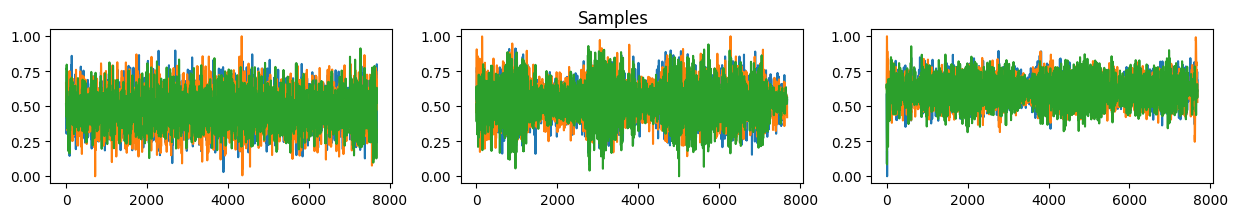

Pretrain dataloader: 70
Train dataloader: 1
Val dataloader: 1
Test dataloader: 1
model 1 conv depth, finetune, 60 s, beta-VAE is created
Test data point shape: torch.Size([1, 3, 7680])
Test inference result length: 4
Test reconstruct shape: torch.Size([1, 3, 7680])
Test encode shape: torch.Size([1, 48, 960])
Optimizer AdamW is instantiated
Scheduler ReduceLROnPlateau is instantiated
Logging via WandB


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmitriykornilov (dmitriykornilov_team). Use `wandb login --relogin` to force relogin


#################### 1 conv depth, finetune, 60 s, beta-VAE ####################
{
    "project_name": "EEG_depression_classification",
    "method": "direct restoration",
    "save_path": "model_weights/",
    "log_path": "logs/",
    "hash": "0xc3f302bd",
    "dataset": {
        "dataloader": {
            "batch_size": 256,
            "num_workers": 0
        },
        "samples_shape": [
            3,
            7680
        ],
        "train": {
            "pretrain": {
                "source": {
                    "name": "TUAB",
                    "file": "Data/TUAB/dataset_128_60.0.pkl"
                },
                "size": null,
                "n_samples": 17727,
                "preprocessing": {
                    "is_squeeze": false,
                    "is_unsqueeze": false,
                    "t_max": null
                },
                "steps": {
                    "start_epoch": 0,
                    "end_epoch": 10,
                    "step_max":

  0%|                                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 0
##### Training... #####
Model is in train mode
Epoch time: 72.71565318107605 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.033,0.967,0.210,9.419,0.033,0.002,0.001,0.000,0.180,0.033,0.609,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (50, 48)
Evaluation time: 9.96282172203064 s
Epoch time: 10.06969666481018 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.029,0.971,0.067,9.988,0.029,0.002,0.001,0.000,0.169,0.029,1.221,0.964,0.934,0.727,0.800,0.963,0.052,0.964,0.056,0.684,0.173,0.682,0.187,0.947,0.429,0.649,0.803,0.529,0.600,0.696,0.358,0.703,0.369,0.427,0.254,0.427,0.260,1.000,0.273


 10%|███████████████████▏                                                                                                                                                                            | 1/10 [01:22<12:25, 82.86s/it]

New best classifier accuracy = 0.426691480659863 on epoch 0
Epoch 1
##### Training... #####
Model is in train mode
Epoch time: 72.46360898017883 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.023,0.977,0.275,10.764,0.023,0.001,0.001,0.000,0.153,0.023,0.583,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.1362459659576416 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.024,0.976,0.093,10.736,0.024,0.002,0.001,0.000,0.156,0.024,0.641


 20%|██████████████████████████████████████▍                                                                                                                                                         | 2/10 [02:35<10:14, 76.85s/it]

Epoch 2
##### Training... #####
Model is in train mode
Epoch time: 71.35131525993347 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.019,0.981,0.296,11.540,0.019,0.001,0.001,0.000,0.139,0.019,0.578,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.12856364250183105 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.023,0.977,0.085,10.924,0.023,0.002,0.001,0.000,0.152,0.023,1.031


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                      | 3/10 [03:47<08:40, 74.42s/it]

Epoch 3
##### Training... #####
Model is in train mode
Epoch time: 72.11062598228455 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.017,0.983,0.308,12.201,0.017,0.001,0.001,0.000,0.129,0.017,0.567,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.13097882270812988 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.020,0.980,0.109,11.561,0.020,0.002,0.001,0.000,0.142,0.020,0.527


 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 4/10 [04:59<07:21, 73.57s/it]

Epoch 4
##### Training... #####
Model is in train mode
Epoch time: 72.53787517547607 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.013,0.987,0.309,13.280,0.013,0.001,0.001,0.000,0.115,0.013,0.552,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.1288738250732422 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.037,0.963,0.114,9.463,0.037,0.002,0.001,0.000,0.192,0.037,0.603


 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 5/10 [06:12<06:06, 73.26s/it]

Epoch 5
##### Training... #####
Model is in train mode
Epoch time: 72.19126844406128 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.010,0.990,0.316,14.859,0.010,0.001,0.001,0.000,0.098,0.010,0.542,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (50, 48)
Evaluation time: 9.54259729385376 s
Epoch time: 9.667562484741211 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,clf.d.train.average_precision,clf.d.train.roc_auc,clf.d.train.accuracy,clf.d.train.f1,clf.d.train.average_precision.bs,clf.d.train.average_precision.se.bs,clf.d.train.roc_auc.bs,clf.d.train.roc_auc.se.bs,clf.d.train.accuracy.bs,clf.d.train.accuracy.se.bs,clf.d.train.f1.bs,clf.d.train.f1.se.bs,clf.d.train.sensitivity,clf.d.train.specificity,clf.d.test.average_precision,clf.d.test.roc_auc,clf.d.test.accuracy,clf.d.test.f1,clf.d.test.average_precision.bs,clf.d.test.average_precision.se.bs,clf.d.test.roc_auc.bs,clf.d.test.roc_auc.se.bs,clf.d.test.accuracy.bs,clf.d.test.accuracy.se.bs,clf.d.test.f1.bs,clf.d.test.f1.se.bs,clf.d.test.sensitivity,clf.d.test.specificity
0,0.035,0.965,0.119,9.824,0.035,0.002,0.001,0.000,0.186,0.035,0.528,0.983,0.962,0.697,0.792,0.984,0.034,0.983,0.035,0.678,0.175,0.676,0.175,0.950,0.308,0.548,0.600,0.353,0.421,0.573,0.379,0.579,0.384,0.290,0.228,0.297,0.221,0.800,0.167


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 6/10 [07:33<05:04, 76.21s/it]

Epoch 6
##### Training... #####
Model is in train mode
Epoch time: 72.76188516616821 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.009,0.991,0.334,15.116,0.009,0.001,0.001,0.000,0.095,0.009,0.534,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.13161110877990723 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.021,0.979,0.118,12.126,0.021,0.002,0.001,0.000,0.144,0.021,0.688


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7/10 [08:46<03:45, 75.14s/it]

Epoch 7
##### Training... #####
Model is in train mode
Epoch time: 72.20817351341248 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.009,0.991,0.345,15.233,0.009,0.001,0.001,0.000,0.094,0.009,0.528,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.12244868278503418 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.015,0.985,0.127,12.997,0.015,0.002,0.001,0.000,0.121,0.015,0.533


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 8/10 [09:59<02:28, 74.26s/it]

Epoch 8
##### Training... #####
Model is in train mode
Epoch time: 71.78010034561157 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.009,0.991,0.355,15.303,0.009,0.001,0.001,0.000,0.094,0.009,0.524,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.1273176670074463 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.021,0.979,0.151,11.579,0.021,0.002,0.001,0.000,0.146,0.021,0.547


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 9/10 [11:11<01:13, 73.54s/it]

Epoch 9
##### Training... #####
Model is in train mode
Epoch time: 72.6657361984253 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.009,0.991,0.365,15.387,0.009,0.001,0.001,0.000,0.093,0.009,0.521,0.001


##### Validation... #####
Model is in evaluation mode
Epoch time: 0.12468266487121582 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl
0,0.022,0.978,0.146,11.748,0.022,0.002,0.001,0.000,0.147,0.022,0.615


  0%|                                                                                                                                                                                                        | 0/75 [00:00<?, ?it/s]

Epoch 10
##### Training... #####
Model is in train mode
Epoch time: 0.4304518699645996 s


,loss,metric,pearson_correlation,snr_db,loss_ampl,loss_vel,loss_acc,loss_frq,RMSE,-log p(x|z),kl,lr
0,0.010,0.990,0.149,14.352,0.010,0.002,0.001,0.000,0.102,0.010,0.515,0.001


##### Validation... #####
Model is in evaluation mode
Classifier/regressor metrics evaluation...
Embeddings shape: (50, 48)


In [ ]:
all_results = []
for config in experiments:
    exp_results = {
        config['model']["model_description"] : train(config, verbose=3)
    }
    all_results.append(exp_results)
    with open(os.path.join(config["log_path"], "all_results_" + config["model"]["model_description"].replace(" ", "_").replace("/", ".")), "w") as f:
        json.dump(exp_results, f, indent=4, ensure_ascii=False)
    with open("current_results.json", "w") as f:
        json.dump(all_results, f, indent=4, ensure_ascii=False)